## Download ckpts

In [ ]:
!mkdir models
!pip install gdown -U
# Download random-mask sd15 & sdxl brushnet checkpoints
!gdown https://drive.google.com/drive/folders/1hCYIjeRGx3Zk9WZtQf0s3nDGfeiwqTsN --folder -O models/
!gdown https://drive.google.com/drive/folders/1H2annwRr1HkUppbHe2gt9HHqO59EHXKc --folder -O models/

In [ ]:
# Download sd15 checkpoint
!wget https://huggingface.co/SG161222/Realistic_Vision_V6.0_B1_noVAE/resolve/main/Realistic_Vision_V6.0_NV_B1.safetensors?download=true -O models/Realistic_Vision_V6.0_NV_B1.safetensors

## Inference

In [1]:
import cv2
import random
import diffusers

import numpy as np

from PIL import Image, ImageOps
from diffusers import UniPCMultistepScheduler

In [2]:
# Diffusers patching

from unet_2d_condition import UNet2DConditionModel as UNet2DConditionModel_patch
from diffusers.models.unets import unet_2d_condition
unet_2d_condition.UNet2DConditionModel = UNet2DConditionModel_patch

In [3]:
import torch
from diffusers import AutoencoderKL
from brushnet import BrushNetModel
from pipeline_brushnet import StableDiffusionBrushNetPipeline
from pipeline_brushnet_sdxl import StableDiffusionXLBrushNetPipeline

In [4]:
# input brushnet ckpt path
brushnet_path = "models/random_mask_brushnet_ckpt/"

brushnet = BrushNetModel.from_pretrained(brushnet_path, torch_dtype=torch.float16)

In [5]:
# choose the base model here
base_model_path = "models/Realistic_Vision_V6.0_NV_B1.safetensors"
# base_model_path = "runwayml/stable-diffusion-v1-5"


pipe = StableDiffusionBrushNetPipeline.from_single_file(
    base_model_path, brushnet=brushnet, torch_dtype=torch.float16, low_cpu_mem_usage=False
)

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']


In [6]:
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed or when using Torch 2.0.
pipe.enable_xformers_memory_efficient_attention()
# memory optimization.
pipe.enable_model_cpu_offload()

In [26]:
init_image = Image.open('imgs/test_image_cola.png')
# extract mask from alpha channel
mask_image = ImageOps.invert(init_image.getchannel("A"))

print(f'Size = {init_image.size}')

randomize_seed = True
prompt = "Photo of can laying on the beach"
negative_prompt = "blurry, poor quality, distorted, woman, man, people, body, mutated"
num_inference_steps = 20
guidance_scale = 7.5
control_strength = 1.0
blended = True

Size = (768, 768)


In [30]:
generator = torch.Generator("cuda").manual_seed(random.randint(0,2147483647) if randomize_seed else seed)

image = pipe(
    [prompt]*2, 
    init_image, 
    mask_image, 
    num_inference_steps=num_inference_steps, 
    guidance_scale=guidance_scale,
    generator=generator,
    brushnet_conditioning_scale=float(control_strength),
    negative_prompt=[negative_prompt]*2,
).images

if blended:
    if control_strength<1.0:
        raise gr.Error('Using blurred blending with control strength less than 1.0 is not allowed')
    blended_image=[]
    mask = np.array(mask_image) / 255
    mask = mask[..., np.newaxis]
    original_image = np.array(init_image)[..., :3]
    # blur, you can adjust the parameters for better performance
    mask_blurred = cv2.GaussianBlur(mask*255, (21, 21), 0)/255
    mask_blurred = mask_blurred[:,:,np.newaxis]
    mask = 1-(1-mask) * (1-mask_blurred)
    for image_i in image:
        image_np=np.array(image_i)
        image_pasted=original_image * (1-mask) + image_np*mask

        image_pasted=image_pasted.astype(image_np.dtype)
        blended_image.append(Image.fromarray(image_pasted))


  0%|          | 0/20 [00:00<?, ?it/s]

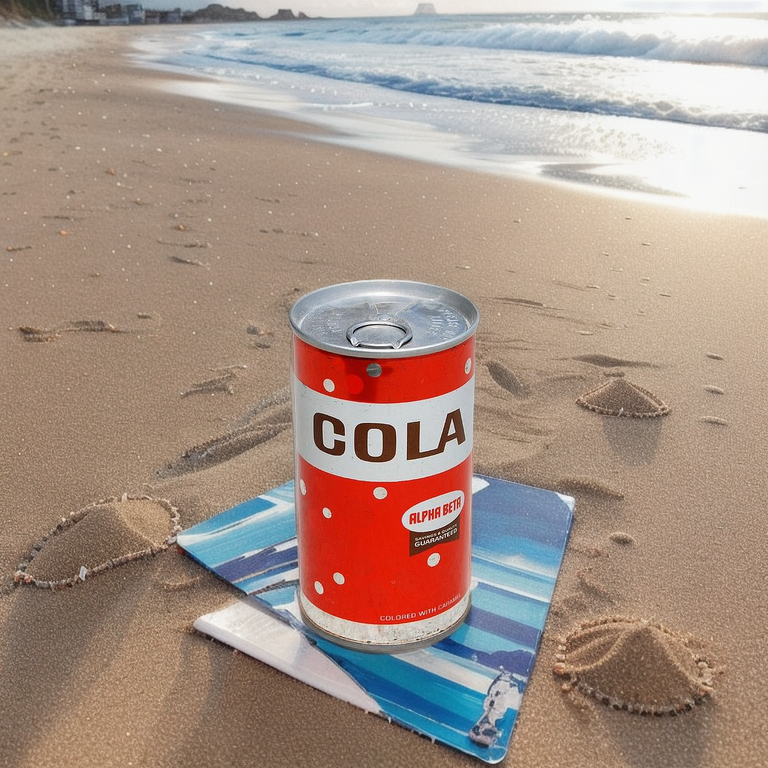

In [31]:
image[0]

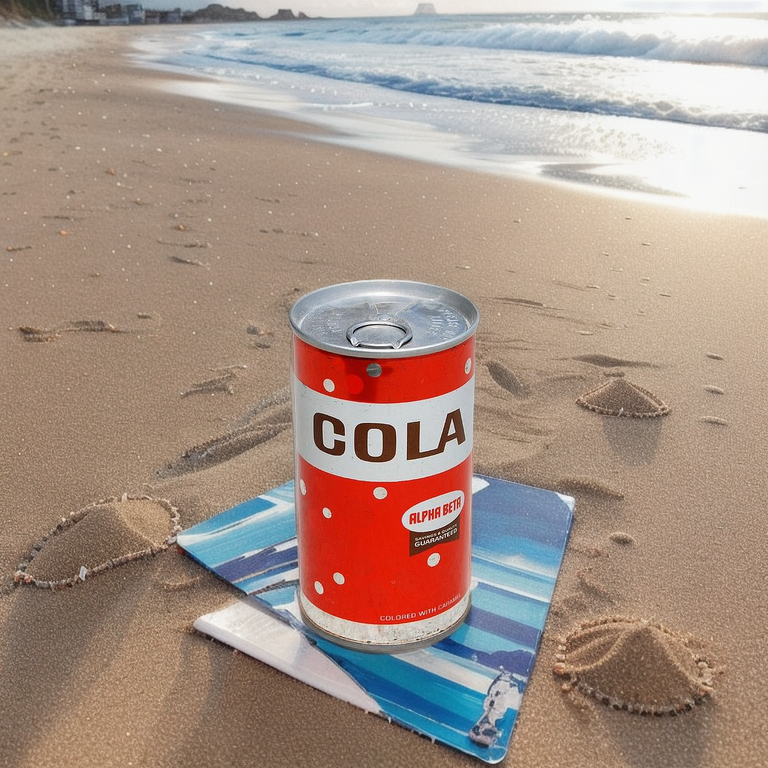

In [32]:
blended_image[0]

## SDXL version

In [4]:
# input brushnet ckpt path
brushnet_path = "models/random_mask_brushnet_ckpt_sdxl_v0/"

brushnet = BrushNetModel.from_pretrained(brushnet_path, torch_dtype=torch.float16)

In [5]:
# choose the base model here
base_model_path = "models/juggernautXL_v7Rundiffusion.safetensors"
# base_model_path = "runwayml/stable-diffusion-v1-5"


pipe = StableDiffusionXLBrushNetPipeline.from_single_file(
    base_model_path, brushnet=brushnet, torch_dtype=torch.float16, low_cpu_mem_usage=False
)
# change to sdxl-vae-fp16-fix to avoid nan in VAE encoding when using fp16
pipe.vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
Some weights of the model checkpoint were not used when initializing CLIPTextModelWithProjection: 
 ['text_model.embeddings.position_ids']


In [6]:
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed or when using Torch 2.0.
pipe.enable_xformers_memory_efficient_attention()
# memory optimization.
pipe.enable_model_cpu_offload()

In [7]:
init_image = Image.open('imgs/test_image_cola.png')
# extract mask from alpha channel
mask_image = ImageOps.invert(init_image.getchannel("A"))

print(f'Size = {init_image.size}')

randomize_seed = True
prompt = "Photo of can laying on the beach"
negative_prompt = "blurry, poor quality, distorted, woman, man, people, body, mutated"
num_inference_steps = 30
guidance_scale = 4
control_strength = 1.0
blended = True

Size = (768, 768)


In [10]:
generator = torch.Generator().manual_seed(random.randint(0,2147483647) if randomize_seed else seed)

image = pipe(
    [prompt],
    [prompt],
    init_image, 
    mask_image, 
    num_inference_steps=num_inference_steps, 
    guidance_scale=guidance_scale,
    generator=generator,
    brushnet_conditioning_scale=float(control_strength),
    negative_prompt=[negative_prompt],
    negative_prompt_2=[negative_prompt]
).images

if blended:
    if control_strength<1.0:
        raise gr.Error('Using blurred blending with control strength less than 1.0 is not allowed')
    blended_image=[]
    mask = np.array(mask_image) / 255
    mask = mask[..., np.newaxis]
    original_image = np.array(init_image)[..., :3]
    # blur, you can adjust the parameters for better performance
    mask_blurred = cv2.GaussianBlur(mask*255, (21, 21), 0)/255
    mask_blurred = mask_blurred[:,:,np.newaxis]
    mask = 1-(1-mask) * (1-mask_blurred)
    for image_i in image:
        image_np=np.array(image_i)
        image_pasted=original_image * (1-mask) + image_np*mask

        image_pasted=image_pasted.astype(image_np.dtype)
        blended_image.append(Image.fromarray(image_pasted))


  0%|          | 0/30 [00:00<?, ?it/s]

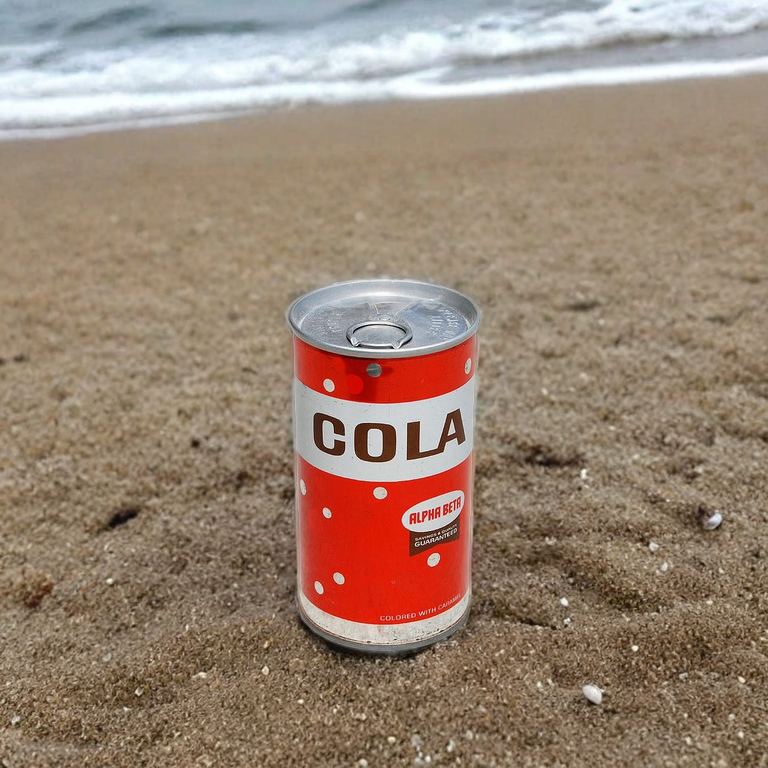

In [25]:
image[0]

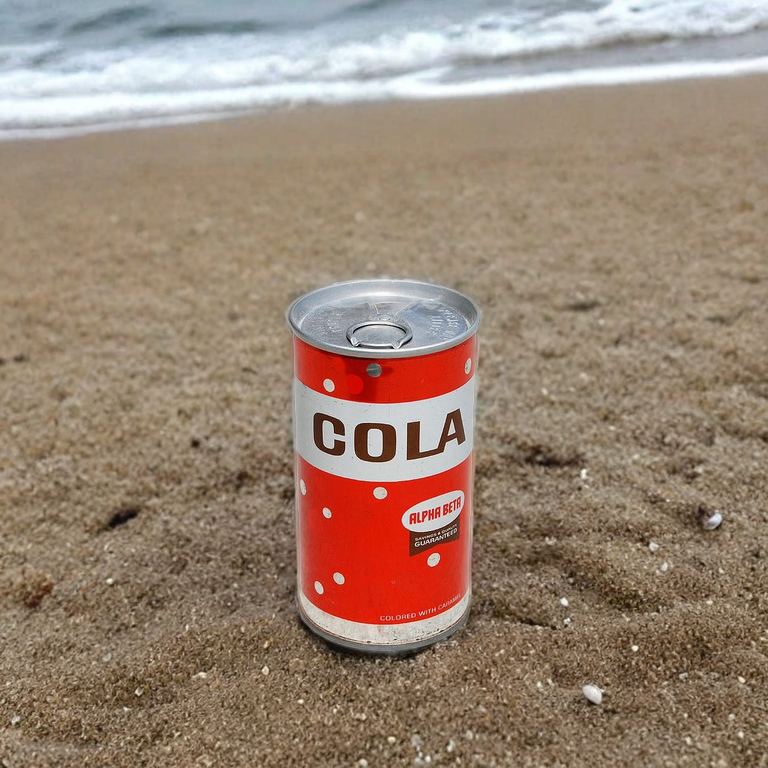

In [26]:
blended_image[0]